E_GS =  [-5.43151958]
gap =  1.0279826385971234
||H|| =  5.4315195827374945
|<psi0|psiGS>| =  4.163336342344337e-17
Frequency domain         =  0.45240354537963867  s
Overlap  =  0.9982863540644639
Energy   =  -5.424626790340384
Time domain (coherent)   =  0.19037270545959473  s
Overlap  =  0.9932365879705912
Energy   =  -5.405196660411766
Time domain (decoherent, batch) =  15.24639081954956  s
Overlap  =  0.9934694498017769
Energy   =  -5.406100405935978


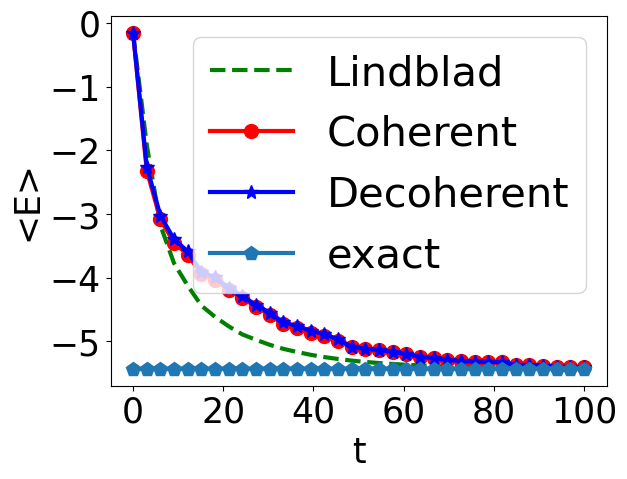

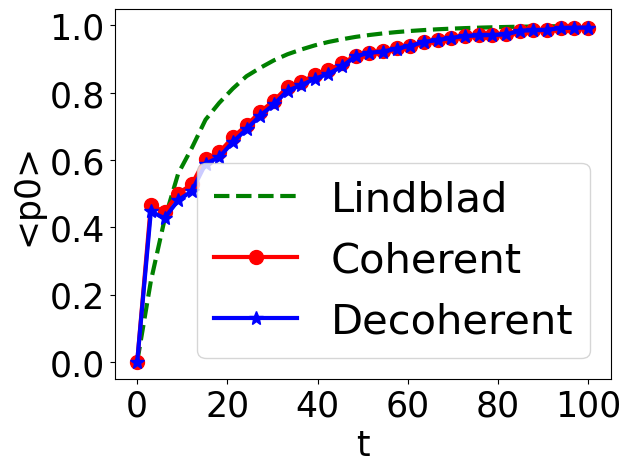

In [6]:
# %load tfim1d.py
"""
Test Lindblad based method for ground state preparation for TFIM.

Last revision: 05/20/2023
"""
import numpy as np # generic math functions
import scipy.sparse
import scipy.linalg as la
import scipy.io
from scipy.special import erf
from scipy.linalg import expm
from numpy import pi
from numpy.fft import fft
from time import time


from quspin.operators import hamiltonian # Hamiltonians and operators
from quspin.basis import spin_basis_1d
import matplotlib.pyplot as plt
from qutip import Qobj, mesolve
from lindblad import Lindblad

##### define model parameters #####
L=4 # system size
J=1.0 # spin zz interaction
g=1.2 # z magnetic field strength
	
##### define spin model
# site-coupling lists (PBC for both spin inversion sectors)
h_field=[[-g,i] for i in range(L)]
J_zz=[[-J,i,i+1] for i in range(L-1)] # no PBC
# define spin static and dynamic lists
static =[["zz",J_zz],["x",h_field]] # static part of H
dynamic=[] # time-dependent part of H
# construct spin basis in pos/neg spin inversion sector depending on APBC/PBC
spin_basis = spin_basis_1d(L=L)
# build spin Hamiltonians
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
H=hamiltonian(static,dynamic,basis=spin_basis,dtype=np.float64,**no_checks)
# calculate spin energy levels
E_GS,psi_GS = H.eigsh(k=1,which="SA")
psi_GS = psi_GS.flatten()
print('E_GS = ', E_GS)

H_mat = np.array(H.todense())
E_H , psi_H = la.eigh(H_mat)
gap = E_H[1] - E_H[0]
print('gap = ', gap)
print('||H|| = ', la.norm(H_mat,2))

a = 8.0
da = 1.0
b  = gap
db = gap

filter_params = {'a': a, 'b': b, 'da': da, 'db': db} 

T_kraus = 4.0 / np.min([da, db])
Nt_kraus = 100
# Nt_kraus = int(5/db/(2*np.pi/(4*a)))

A = hamiltonian([ ['z',[[1.0,0]]] ],[],basis=spin_basis,dtype=np.float64,**no_checks)
A_mat = np.array(A.todense())

lb = Lindblad(H_mat, A_mat, filter_params)

if False:
    tgrid = np.linspace(-T_kraus, T_kraus, 2000)
    # floc_tgrid = np.array([lb.filter_time_localized(t) for t in tgrid])
    f_tgrid    = np.array([lb.filter_time(t) for t in tgrid])
    # plt.plot(tgrid, floc_tgrid, 'b-o')
    plt.plot(tgrid, f_tgrid, 'r-.')
    plt.xlabel('t')
    plt.ylabel('f(t)')
    plt.show()

    wgrid = np.linspace(-2*lb.filter_a, 2*lb.filter_a, 100)

    # floc_wgrid = np.array([lb.filter_freq_localized(w) for w in wgrid])
    f_wgrid = np.array([lb.filter_freq(w) for w in wgrid])
    # plt.plot(wgrid, floc_wgrid.real, 'b-o')
    plt.plot(wgrid, f_wgrid.real, 'r-.')
    plt.xlabel('w')
    plt.ylabel(r'$\hat f(w)$')
    plt.show()
    
# fix the random seed
np.random.seed(seed=1)
vt = np.random.randn(lb.Ns)
# worst case in some sense: make psi0 and psi_GS orthogonal
psi0 = vt.copy()
psi0 -= psi_GS * np.vdot(psi_GS,psi0)
psi0 = psi0 / la.norm(psi0)

#    psi0 = psi_GS.reshape(-1)
print('|<psi0|psiGS>| = ', np.abs(np.vdot(psi_GS,psi0)))


H_obj = Qobj(H_mat)
zero_obj = Qobj(np.zeros_like(H_mat))

rho_GS_obj = Qobj(np.outer(psi_GS, psi_GS.conj()))

# Simulation parameters

T = 100
num_t = int(T/3)
num_segment = 3
num_rep = 100
times = np.arange(num_t+1) * (T/num_t)
is_etarandom = False
intorder = 2

# Solve

mode = 'mesolve'
t_start = time()
lb.construct_kraus_coherent_freq()
result = mesolve(H_obj, Qobj(psi0), times, [Qobj(lb.A_kraus)],
            [H_obj, rho_GS_obj])
avg_H_e = result.expect[0]
avg_pGS_e = result.expect[1]
t_end = time()
print('Frequency domain         = ', t_end - t_start, ' s')
print('Overlap  = ', avg_pGS_e[-1])
print('Energy   = ', avg_H_e[-1])

mode = 'coherent'
t_start = time()
lb.construct_kraus_coherent_time(T_kraus, Nt_kraus)
times, avg_H_c, avg_pGS_c, _= lb.evolve_kraus_coherent(T, num_t, psi0,
        num_rep, psi_GS, is_etarandom = is_etarandom)
t_end = time()
print('Time domain (coherent)   = ', t_end - t_start, ' s')
print('Overlap  = ', avg_pGS_c[-1])
print('Energy   = ', avg_H_c[-1])
   
mode = 'decoherent'
t_start = time()
times, avg_H_de, avg_pGS_de, _, _= lb.evolve_kraus_decoherent_batch(T, num_t,
        num_segment, psi0, num_rep, T_kraus, Nt_kraus,
        psi_GS, intorder=intorder, is_etarandom = is_etarandom)
t_end = time()
print('Time domain (decoherent, batch) = ', t_end - t_start, ' s')
print('Overlap  = ', avg_pGS_de[-1])
print('Energy   = ', avg_H_de[-1])


plt.figure()
plt.plot(times, avg_H_e, 'g--', label='Lindblad', linewidth=3, markersize=10)
plt.plot(times, avg_H_c, 'r-o', label='Coherent', linewidth=3, markersize=10)
plt.plot(times, avg_H_de,'b-*', label='Decoherent', linewidth=3, markersize=10)
plt.plot(times, np.ones_like(times)*E_GS, 'p-', label='exact', linewidth=3,markersize=10)
plt.legend()
plt.xlabel('t',fontsize=25)
plt.ylabel('<E>',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=30)
# plt.savefig('TFIM_6_energy.pdf')
plt.show()

plt.figure()
plt.plot(times, avg_pGS_e, 'g--', label='Lindblad', linewidth=3, markersize=10)
plt.plot(times, avg_pGS_c, 'r-o', label='Coherent', linewidth=3, markersize=10)
plt.plot(times, avg_pGS_de,'b-*', label='Decoherent', linewidth=3, markersize=10)
plt.legend()
plt.xlabel('t',fontsize=25)
plt.ylabel('<p0>',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=30)
#plt.savefig('TFIM_6_overlap.pdf')
plt.show()



Frequency domain         =  0.43248701095581055  s
Overlap  =  0.998286354064463
Energy   =  -5.424626790340381
Time domain (coherent)   =  0.45986390113830566  s
Overlap  =  0.9990502606691624
Energy   =  -5.4276117456279644
Time domain (decoherent, batch) =  18.166077375411987  s
Overlap  =  0.998440854211543
Energy   =  -5.425263279460053


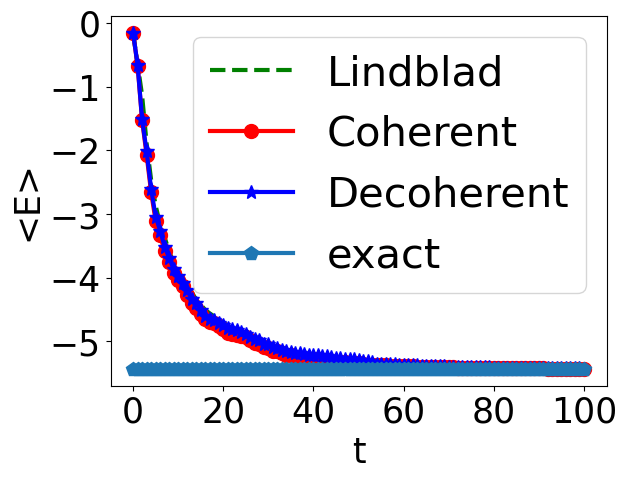

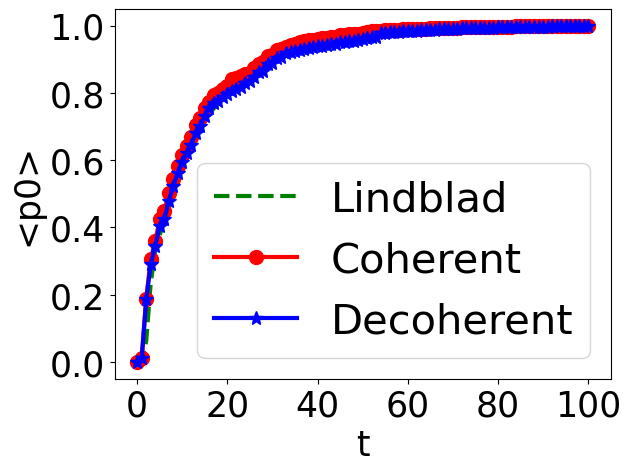

In [7]:

# Simulation parameters

T = 100
num_t = int(T)
num_segment = 1
num_rep = 100
times = np.arange(num_t+1) * (T/num_t)
is_etarandom = False
intorder = 2

# Solve

mode = 'mesolve'
t_start = time()
lb.construct_kraus_coherent_freq()
result = mesolve(H_obj, Qobj(psi0), times, [Qobj(lb.A_kraus)],
            [H_obj, rho_GS_obj])
avg_H_e = result.expect[0]
avg_pGS_e = result.expect[1]
t_end = time()
print('Frequency domain         = ', t_end - t_start, ' s')
print('Overlap  = ', avg_pGS_e[-1])
print('Energy   = ', avg_H_e[-1])

mode = 'coherent'
t_start = time()
lb.construct_kraus_coherent_time(T_kraus, Nt_kraus)
times, avg_H_c, avg_pGS_c, _= lb.evolve_kraus_coherent(T, num_t, psi0,
        num_rep, psi_GS, is_etarandom = is_etarandom)
t_end = time()
print('Time domain (coherent)   = ', t_end - t_start, ' s')
print('Overlap  = ', avg_pGS_c[-1])
print('Energy   = ', avg_H_c[-1])
   
mode = 'decoherent'
t_start = time()
times, avg_H_de, avg_pGS_de, _, _= lb.evolve_kraus_decoherent_batch(T, num_t,
        num_segment, psi0, num_rep, T_kraus, Nt_kraus,
        psi_GS, intorder=intorder, is_etarandom = is_etarandom)
t_end = time()
print('Time domain (decoherent, batch) = ', t_end - t_start, ' s')
print('Overlap  = ', avg_pGS_de[-1])
print('Energy   = ', avg_H_de[-1])


plt.figure()
plt.plot(times, avg_H_e, 'g--', label='Lindblad', linewidth=3, markersize=10)
plt.plot(times, avg_H_c, 'r-o', label='Coherent', linewidth=3, markersize=10)
plt.plot(times, avg_H_de,'b-*', label='Decoherent', linewidth=3, markersize=10)
plt.plot(times, np.ones_like(times)*E_GS, 'p-', label='exact', linewidth=3,markersize=10)
plt.legend()
plt.xlabel('t',fontsize=25)
plt.ylabel('<E>',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=30)
# plt.savefig('TFIM_6_energy.pdf')
plt.show()

plt.figure()
plt.plot(times, avg_pGS_e, 'g--', label='Lindblad', linewidth=3, markersize=10)
plt.plot(times, avg_pGS_c, 'r-o', label='Coherent', linewidth=3, markersize=10)
plt.plot(times, avg_pGS_de,'b-*', label='Decoherent', linewidth=3, markersize=10)
plt.legend()
plt.xlabel('t',fontsize=25)
plt.ylabel('<p0>',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=30)
#plt.savefig('TFIM_6_overlap.pdf')
plt.show()
